In [35]:
%load_ext autoreload
%autoreload 2

In [36]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import plot2Dimage, RelL2Loss
from cbsmodel import ConvergentBornSeries
import logging
import sys

$$
\nabla^2 u(x) +\frac{\omega_0^2}{c(x)^2}u(x) = -f(x)
$$
where $\omega_0 = \frac{2\pi}{\lambda}$ is the `angular frequency`, $c(x)$ is the `sound of speed(SOS)` and $f(x)$ is the point source term.

we can set $k =\frac{\omega_0}{c(x)}$, then 
$$
\nabla^2 u(x) +k^2u(x) = -f(x)
$$

In Convergent Born Series, the scatter potential is defined as:
$$
V = k^2 - k^2_0 - i\epsilon
$$

In [37]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
model = ConvergentBornSeries(lamb=1,
                             sos=None,# default homogenous
                             dx=None,
                             src_loc=[100,40],
                             boundary_width=[8,8],
                             boundary_strength=1,
                             boundary_type='PML3').to(device)

In [38]:
model.solve(max_iters=500)
u = model.get_u()

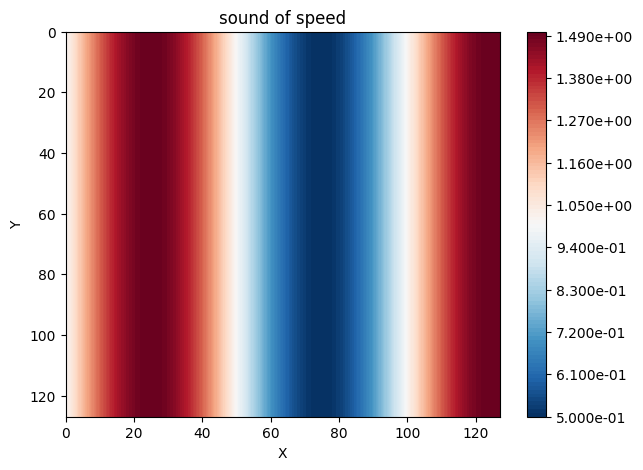

In [39]:
sos = model.sos
plot2Dimage(x_end=sos.size(0),
            y_end=sos.size(1),
            f=sos,
            title='sound of speed')

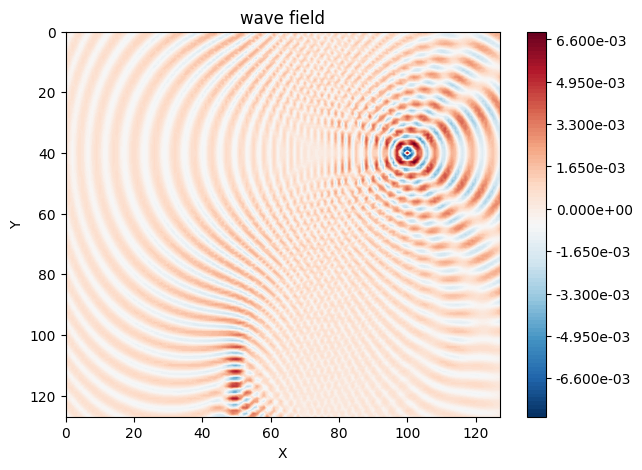

In [40]:
u = torch.real(model.get_u())
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=u,
            title='wave field')

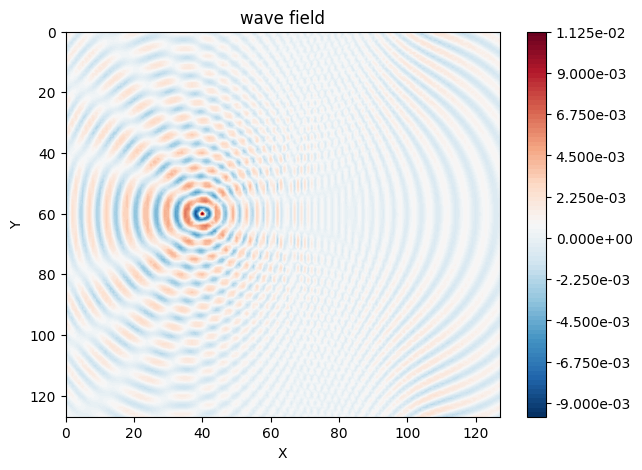

In [41]:
model.set_src_loc(src_loc=[40,60])
model.solve(max_iters=500)
u = model.get_u()
u = torch.real(model.get_u())
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=u,
            title='wave field')

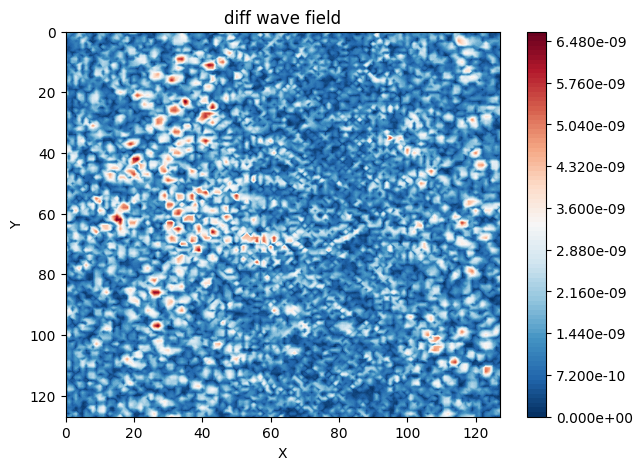

In [42]:
model.solve(max_iters=2000)
u1 = model.get_u()
model.solve(max_iters=5000)
u2 = model.get_u()
u = torch.abs(torch.real(u1-u2))
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=u,
            title='diff wave field')

## Train Phase

In [43]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('train.log',mode='w'),  
        logging.StreamHandler(sys.stdout)
    ]
)

In [46]:
trian_model = ConvergentBornSeries(lamb=1,
                             sos=None,# default homogenous
                             dx=None,
                             src_loc=[40,60],
                             boundary_width=[8,8],
                             boundary_strength=1,
                             boundary_type='PML3').to(device)

optimizer = optim.Adam(trian_model.parameters(),lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.7)
criterion = RelL2Loss()
num_epoch = 100
num_batch = 20
train_iter = 50
loss_list = []
data_train = torch.load('./data/train_data_2000.pth',weights_only=False)
num_train = data_train['wavefield'].shape[0]
logging.info(f"Using device: {device}")
logging.info(f"Train nums: {num_train}")
logging.info(f"Batch size: {num_batch}")
for i in range(num_epoch):
    for d in range(num_train//num_batch):
        loss = 0
        for b in range(num_batch):
            trian_model.set_src_loc(src_loc=data_train['src_locs'][((num_batch*d)+b)%num_train])
            out = torch.view_as_real(trian_model(max_iters=train_iter,requries_grad=True))
            label = torch.view_as_real(data_train['wavefield'][((num_batch*d)+b)%num_train]).to(out.device)
            loss += criterion(out,label,batch_size=1)
        loss = loss/num_batch
        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
        if (i%1 == 0) and (d%5==0):
            logging.info(f"Epoch: [{i}|{num_epoch}], Batch: [{d:2}|{num_train//num_batch}], loss: {loss.item():.4e}, Lr: {scheduler.get_last_lr()[0]:.4e}")
    scheduler.step()

2024-09-27 05:56:59: Using device: cuda:0
2024-09-27 05:56:59: Train nums: 2000
2024-09-27 05:56:59: Batch size: 20
2024-09-27 05:57:00: Epoch: [0|100], Batch: [  0|100], loss: 7.5678e-01, Lr: 1.0000e-05
2024-09-27 05:57:03: Epoch: [0|100], Batch: [  5|100], loss: 7.4467e-01, Lr: 1.0000e-05
2024-09-27 05:57:07: Epoch: [0|100], Batch: [ 10|100], loss: 7.2532e-01, Lr: 1.0000e-05
2024-09-27 05:57:10: Epoch: [0|100], Batch: [ 15|100], loss: 7.0083e-01, Lr: 1.0000e-05
2024-09-27 05:57:13: Epoch: [0|100], Batch: [ 20|100], loss: 6.9263e-01, Lr: 1.0000e-05
2024-09-27 05:57:16: Epoch: [0|100], Batch: [ 25|100], loss: 6.7993e-01, Lr: 1.0000e-05
2024-09-27 05:57:19: Epoch: [0|100], Batch: [ 30|100], loss: 6.6950e-01, Lr: 1.0000e-05
2024-09-27 05:57:22: Epoch: [0|100], Batch: [ 35|100], loss: 6.6435e-01, Lr: 1.0000e-05
2024-09-27 05:57:25: Epoch: [0|100], Batch: [ 40|100], loss: 6.5747e-01, Lr: 1.0000e-05
2024-09-27 05:57:28: Epoch: [0|100], Batch: [ 45|100], loss: 6.5888e-01, Lr: 1.0000e-05
2024

KeyboardInterrupt: 

Text(0.5, 1.0, 'train loss')

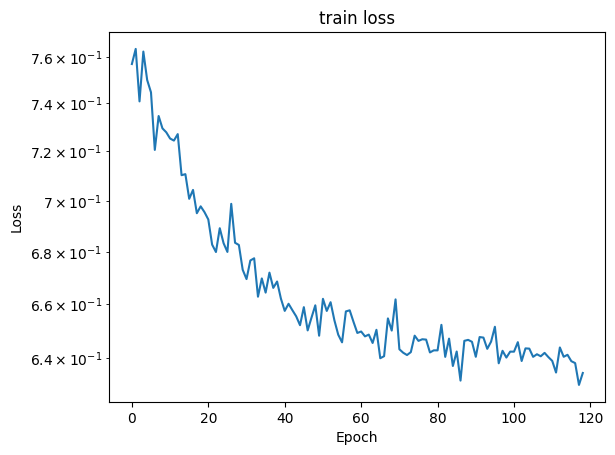

In [47]:
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train loss')

In [79]:
test_src_loc = data_train['src_locs'][0]
test_src_loc = [10, 10]

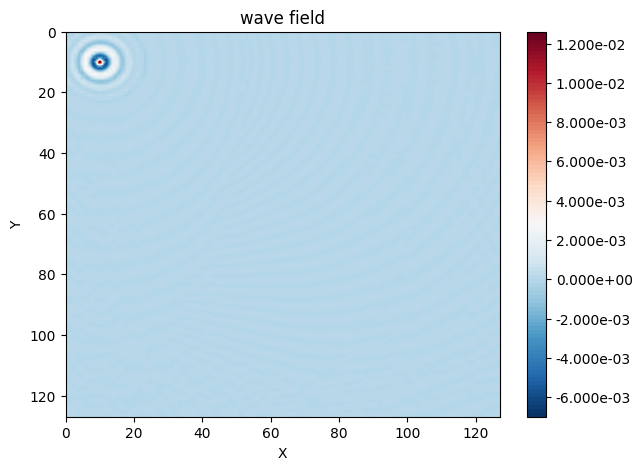

In [81]:
trian_model.set_src_loc(src_loc=test_src_loc)
trian_model.solve(10)
u = trian_model.get_u()
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=torch.real(u),
            title='wave field')

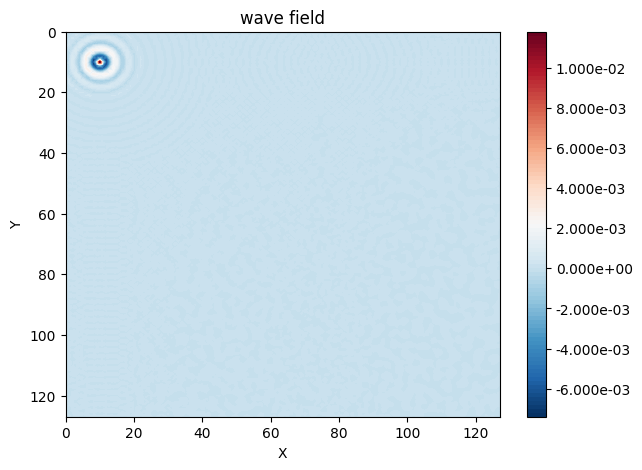

In [82]:
model.set_src_loc(src_loc=test_src_loc)
model.solve(10)
u = model.get_u()
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=torch.real(u),
            title='wave field')

In [84]:
g0_tilde_ori = model.g0.detach().cpu()
g0_tilde_opt = trian_model.g0.detach().cpu()

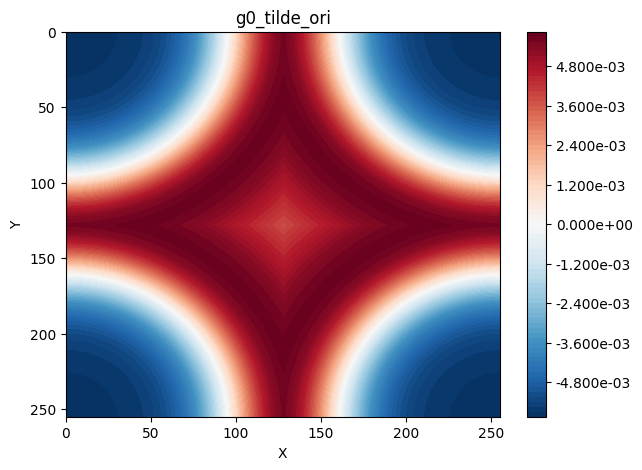

In [85]:
plot2Dimage(x_end=g0_tilde_ori.size(0),
            y_end=g0_tilde_ori.size(1),
            f=torch.real(g0_tilde_ori),
            title='g0_tilde_ori')

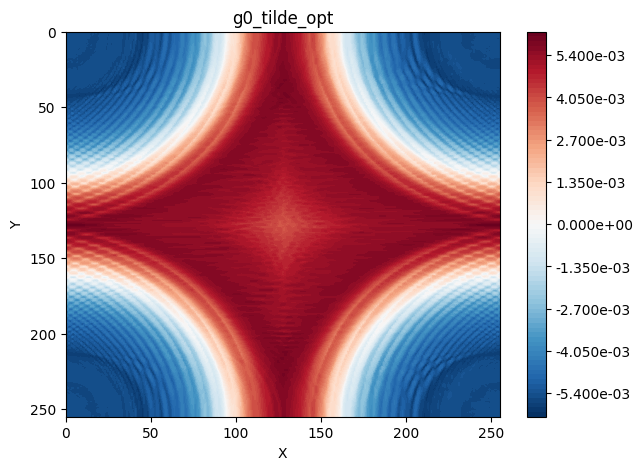

In [86]:
plot2Dimage(x_end=g0_tilde_opt.size(0),
            y_end=g0_tilde_opt.size(1),
            f=torch.real(g0_tilde_opt),
            title='g0_tilde_opt')

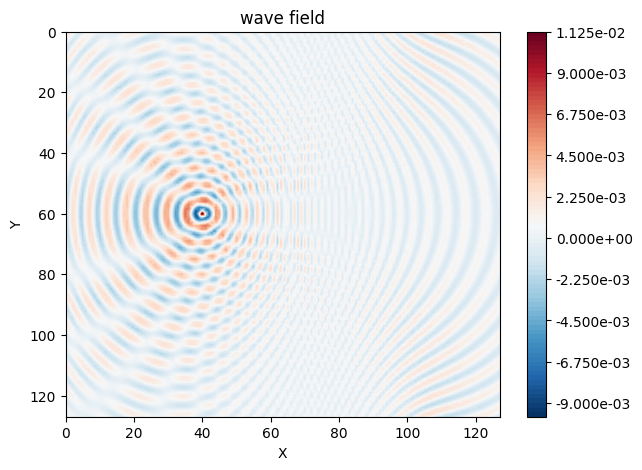

In [354]:
trian_model.set_src_loc(src_loc=[60,60])
trian_model.solve(10)
u = model.get_u()
plot2Dimage(x_end=u.size(0),
            y_end=u.size(1),
            f=torch.real(u),
            title='wave field')